✅ Using device: cpu

🚀 Training ResNet18 (Quick Mode)...
ResNet18 Epoch 1/2 - Train: 27.3% | Val: 38.0%
ResNet18 Epoch 2/2 - Train: 95.7% | Val: 55.0%


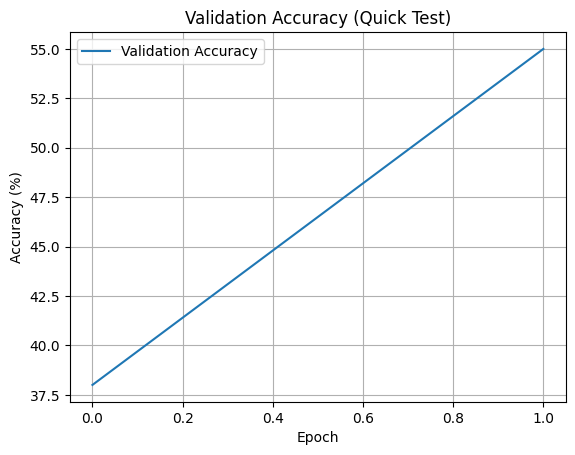

🖼 Prediction: cat


In [2]:
# Step 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from PIL import Image
import os

# Step 2: Configure Device and Labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Load CIFAR-10 (Smaller Subset for Speed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Only take 300 training and 100 test images to make it FAST
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_subset = Subset(train_data, range(300))
val_subset = Subset(test_data, range(100))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Step 4: Define Train/Eval Function
def train_and_evaluate(model, name, num_epochs=2):  # only 2 epochs for speed
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_accs.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accs.append(100 * correct / total)
        print(f"{name} Epoch {epoch+1}/{num_epochs} - Train: {train_accs[-1]:.1f}% | Val: {val_accs[-1]:.1f}%")

    return model, train_accs, val_accs

# Step 5: Get a Model (use only ResNet18 for speed)
def get_model(name="resnet"):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

# Step 6: Train One Model
print("\n🚀 Training ResNet18 (Quick Mode)...")
model = get_model()
trained_model, train_acc, val_acc = train_and_evaluate(model, "ResNet18")

# Step 7: Plot Accuracy
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Validation Accuracy (Quick Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Predict on Custom Image
def predict_image(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)
        print(f"🖼 Prediction: {class_names[predicted.item()]}")

# Quick test image
sample_img = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
os.system(f"wget -q {sample_img} -O test_image.jpg")
predict_image("test_image.jpg", trained_model)
